In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate, linalg, optimize, sparse
import statistics
import numpy.polynomial
import ipywidgets as widgets
from IPython.display import display
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plab

# Defining functions

## Basic functions

In [3]:
def closest(lst, K):
    
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return lst[idx]
     
def closest_indx(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return idx     

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def FD_dist(HWHM, center, wavelengths_to_evaluate, height = 1):
    return height*(1/(1+np.exp((center-wavelengths_to_evaluate)/HWHM)))

def counts_to_irradiance(flame_data, integration_time, k_filepath):
    
    k_data = np.loadtxt(k_filepath,skiprows=1) #
    irradiance = np.zeros(flame_data.shape)
    for i in range(len(irradiance[:,0])):
        irradiance[i,0] = flame_data[i,0]
        k_data_closest_index = np.where(k_data[:,0] == closest(k_data[:,0],flame_data[i,0]))[0]
        irradiance[i,1] = flame_data[i,1]*k_data[k_data_closest_index[0],1]/integration_time
        
    return irradiance


## c_matrix related functions

In [4]:
def c_matrix_generator(
input_spectra_fit,                  #This is the full spectra to generate the c_matrix
Red_sweep = True,               #If you want a red sweap, this should be True, if it is False then blue sweep is calculated.
Derivative = False,             #If true, the output gives also the derivative of each spectra with respect to the wavelength. 
Real_data = False,              #If true, we will need to pass the stepf_parameters matrix of the corresponding sweep.
stepf_parameters = 0,           #This is a numpy array containing the RScutwl, center, heigth, hwhm and constant of the stepfunction. (RScutwl is the reference cut wavelength that we have, but for the funtion of the stepfunction one takes the realcutwl which shold be the same for a RS but different for a BS)
c_matrix_min_wl = 360,          #The minimum wavelength of the c_matrix spectras (and also the resulting EQE). Redomended value 400 because it is the minimum of EQE measures
c_matrix_max_wl = 1000,         #The maximum wavelength of the c_matrix spectras (and also the resulting EQE). Recomended value 1000
c_matrix_res_wl = 1,            #The wavelength resolution of the c_matrix spectras (and also the resultin EQE)
c_matrix_min_cutwl = 400,       #The minimum cuting wavelength of the c_matrix spectras
c_matrix_max_cutwl = 810,       #The maximum cutting wavelength of the c_matrix spectras
c_matrix_res_cutwl = 10,        #The cutting wavelength spacing of the c_matrix spectras
c_matrix_stepf_HWHM = 5        #Define the value of this parameter
):
    if not Real_data:
        full_spectra_irradiance_fit = input_spectra_fit
        c_matrix_wl = np.arange(c_matrix_min_wl, c_matrix_max_wl, c_matrix_res_wl)      #These are the wavelengths wherein the c_matrix is evaluated horizontally (its spectras, and therefore the EQE)
        c_matrix_cutwl = np.arange(c_matrix_min_cutwl, c_matrix_max_cutwl, c_matrix_res_cutwl)  #There are the wavelengths wehrein the c_matrix is evaluated verticlaly (therefore, the different cutting wavelengths)
        c_matrix_RS_motor = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))                   #We initialize the red sweep and blue sweep metor matrix
        c_matrix_BS_motor = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))
        c_matrix_full_spectra = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))               #And also the matrix containing all the full spectras for its multiplication with the motor matrix
        
        for i in range(len(c_matrix_full_spectra[:,0])):
            c_matrix_RS_motor[i,:] = FD_dist(c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl)       #We define each row of the RS motor matrix with the FD stepfunction distribution
            c_matrix_BS_motor[i,:] = FD_dist(-c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl)      #The same for the BS motor, in this case the FWHM has to be negative in order to have the blue part of the spectra
            
            if Derivative:                                                                          #If the derivative mode is activated
                c_matrix_RS_motor_derivative = np.zeros(c_matrix_RS_motor.shape)                    #we also need to initialize both RS and BS motor derivative matrices
                c_matrix_BS_motor_derivative = np.zeros(c_matrix_BS_motor.shape)
                for i in range(len(c_matrix_full_spectra[:,0])):
                    c_matrix_RS_motor_derivative [i,:] = FD_dist(c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl)*(1-FD_dist(c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl))  #And calculate them
                    c_matrix_BS_motor_derivative [i,:] = FD_dist(-c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl)*(1-FD_dist(-c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl))

        c_matrix_spectra_single = np.zeros(c_matrix_wl.shape)                                           #We also do the same with the c_matrix full spectra previously fited with splines
        for j in range(len(c_matrix_wl)):                                                           #But in this case we need to make the average around each c_matrix_wl
            actual_wl = c_matrix_wl[j]
            actual_spectra_average = statistics.mean(full_spectra_irradiance_fit(np.linspace(actual_wl-(c_matrix_res_wl/2),actual_wl+(c_matrix_res_wl/2), c_matrix_res_wl*10)))
            c_matrix_spectra_single[j] = 0.1*actual_spectra_average*c_matrix_res_wl*actual_wl/1240 #Here is the key part. This spectra is the one corresponding to the c_matrix with all the multiplication factors (ie, divided by energy of the photon and multiplyed by Q in order to get the current density)
            #The summ of the product between c_matrix_spectra_single and the EQE directly give the Jsc in mA/cm^2 (in thsi case for the full spectra)
        for i in range(len(c_matrix_full_spectra[:,0])):
            c_matrix_full_spectra [i,:] = c_matrix_spectra_single 

    if Real_data:
        full_spectra_irradiance_fit = input_spectra_fit
        c_matrix_wl = np.arange(c_matrix_min_wl, c_matrix_max_wl, c_matrix_res_wl)      #These are the wavelengths wherein the c_matrix is evaluated horizontally (its spectras, and therefore the EQE)
        c_matrix_cutwl = stepf_parameters[:,0]                              #There are the wavelengths wehrein the c_matrix is evaluated verticlaly (therefore, the different cutting wavelengths)
        c_matrix_motor = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))                   #We initialize the red sweep and blue sweep metor matrix. In this case, because the positive/negative information is already presnt in the stepf matrix information, we will define a single motor matrix
        c_matrix_full_spectra = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))               #And also the matrix containing all the full spectras for its multiplication with the motor matrix
        
        for i in range(len(c_matrix_full_spectra[:,0])):
            actual_RScutwl, actual_cutwl, actual_heigh, actual_hwhm, actual_constant = stepf_parameters[i,:]
            c_matrix_motor[i,:] = FD_dist(actual_hwhm, actual_cutwl, c_matrix_wl, height=actual_heigh) + actual_constant      #We define each row of the RS motor matrix with the FD stepfunction distribution
        
        if Derivative:                                                                          #If the derivative mode is activated
            c_matrix_motor_derivative = np.zeros(c_matrix_motor.shape)                    #we also need to initialize both RS and BS motor derivative matrices, which in this case are the same
            for i in range(len(c_matrix_full_spectra[:,0])):
                actual_RScutwl, actual_cutwl, actual_heigh, actual_hwhm, actual_constant = stepf_parameters[i,:]
                #print(actual_heigh)
                c_matrix_motor_derivative [i,:] = FD_dist(actual_hwhm, actual_cutwl, c_matrix_wl, height=1)*actual_heigh*(1-FD_dist(actual_hwhm, actual_cutwl, c_matrix_wl, height=1))  #And calculate them
                    

        c_matrix_BS_motor = c_matrix_motor          #Finally, when the motor matrix is constucted we define the BS and RS motor matrixes as this one, and what we choose initially will return the correct one. 
        c_matrix_RS_motor = c_matrix_motor
        c_matrix_BS_motor_derivative = c_matrix_motor_derivative
        c_matrix_RS_motor_derivative = c_matrix_motor_derivative

        c_matrix_spectra_single = np.zeros(c_matrix_wl.shape)                                           #We also do the same with the c_matrix full spectra previously fited with splines
        for j in range(len(c_matrix_wl)):                                                           #But in this case we need to make the average around each c_matrix_wl
            actual_wl = c_matrix_wl[j]
            actual_spectra_average = statistics.mean(full_spectra_irradiance_fit(np.linspace(actual_wl-(c_matrix_res_wl/2),actual_wl+(c_matrix_res_wl/2), c_matrix_res_wl*10)))
            c_matrix_spectra_single[j] = 0.1*actual_spectra_average*c_matrix_res_wl*actual_wl/1240 #Here is the key part. This spectra is the one corresponding to the c_matrix with all the multiplication factors (ie, divided by energy of the photon and multiplyed by Q in order to get the current density)
            #The summ of the product between c_matrix_spectra_single and the EQE directly give the Jsc in mA/cm^2 (in thsi case for the full spectra)
        for i in range(len(c_matrix_full_spectra[:,0])):
            c_matrix_full_spectra [i,:] = c_matrix_spectra_single 

    if not Derivative:    #If the derivative option is False, we just return the c_matrix
        if Red_sweep:
            c_matrix = c_matrix_RS_motor*c_matrix_full_spectra
        else:
            c_matrix = c_matrix_BS_motor*c_matrix_full_spectra

        return (c_matrix, c_matrix_wl, c_matrix_cutwl)
    
    if Derivative:      #If the derivative option is True, we calculate and return the c_matrix_derivative
        if Red_sweep:
            c_matrix = c_matrix_RS_motor*c_matrix_full_spectra
            c_matrix_derivative = c_matrix_RS_motor_derivative*c_matrix_full_spectra
        else:
            c_matrix = c_matrix_BS_motor*c_matrix_full_spectra
            c_matrix_derivative = c_matrix_BS_motor_derivative*c_matrix_full_spectra

        return (c_matrix, c_matrix_derivative, c_matrix_wl, c_matrix_cutwl)

#This function takes a c_matrix and makes the derivative of it in the vertical direction (along the cuting wavelength direction)
def c_matrix_vertical_derivative (
c_matrix,               #The c_matrix in question
c_matrix_cutwl,         #The cutting wavelength vector of the c_matrix
s_factor=0              #The factor that 
):
    c_matrix_vderivative = np.zeros(c_matrix.shape)
    for j in range(len(c_matrix[0,:])):
        actual_spl_fit = interpolate.UnivariateSpline(c_matrix_cutwl, c_matrix[:,j], s=s_factor)
        c_matrix_vderivative [:,j] = -actual_spl_fit.derivative(n=1)(c_matrix_cutwl)

    return c_matrix_vderivative
    
#This function takes a c_matrix and puts a certain noise to it. 
def c_matrix_noise_adder(
c_matrix_input,             #The c_matrix to put noise
percentage):                #The maximum percentage of this noise (the noise added at each poing will be in between +- this percentage to the magnitude at that point)
    c_matrix_input_noise = np.zeros(c_matrix_input.shape)
    for j in range(len(c_matrix_input[:,0])):
        for i in range(len(c_matrix_input[0,:])):
            c_matrix_input_noise[j,i] = c_matrix_input[j,i]*(100+percentage*np.random.random_sample())/100
    
    return c_matrix_input_noise

#This function is useful to plot all the spectras of a given c_matrix
def c_matrix_plotter(
c_matrix,                   #The c_matrix to plot
c_matrix_wl,                #The correponding c_matrix wavelength vector
legend = False,             #True for plotting the legend
concret_spectra = False,    #If you want to plot a concret spectra, just put here a number or a list of numbers
plotsize = (14,6)):        #True for plotting the legend
    if not concret_spectra:
        fig, ax = plt.subplots(figsize=plotsize)
        for i in range(len(c_matrix[:,0])):
            ax.plot(c_matrix_wl,c_matrix[i,:])
        plt.xlabel('Wavelength [nm]')
    if concret_spectra:
        fig, ax = plt.subplots(figsize=plotsize)
        for i in concret_spectra:
            ax.plot(c_matrix_wl,c_matrix[i,:], label=str(i))
        plt.xlabel('Wavelength [nm]')
        plt.legend()

## Jsc calculation related functions

In [5]:
#This function is used to calculate the Jsc
def Jsc_calculator(
full_spectra_irradiance,        #The full spectra irradiance imput
wl_resolution,                  #The wavelenegth resolution of the calculations
real_EQE_interp,                #The interpolation function of the measured EQE
noise_percentage = 0            #The noise percentage added to the Jsc curve
):
    calculated_Jsc_c_matrix_RS, calculated_Jsc_c_matrix_wl_RS, calculated_Jsc_c_matrix_cutwl_RS = c_matrix_generator(full_spectra_irradiance, Red_sweep=True, Derivative = False, c_matrix_res_wl=wl_resolution)
    calculated_Jsc_c_matrix_BS, calculated_Jsc_c_matrix_wl_BS, calculated_Jsc_c_matrix_cutwl_BS = c_matrix_generator(full_spectra_irradiance, Red_sweep=False, Derivative = False, c_matrix_res_wl=wl_resolution)
    calculated_Jsc_RS = np.zeros(len(calculated_Jsc_c_matrix_RS[:,0]))
    calculated_Jsc_BS = np.zeros(len(calculated_Jsc_c_matrix_BS[:,0]))
    for i in range(len(calculated_Jsc_c_matrix_RS[:,0])):
        calculated_Jsc_RS[i] = sum(calculated_Jsc_c_matrix_RS[i,:]*real_EQE_interp(calculated_Jsc_c_matrix_wl))
        calculated_Jsc_RS[i] = calculated_Jsc_RS[i]*(100+noise_percentage*np.random.random_sample())
        calculated_Jsc_BS[i] = sum(calculated_Jsc_c_matrix_BS[i,:]*real_EQE_interp(calculated_Jsc_c_matrix_wl))
        calculated_Jsc_BS[i] = calculated_Jsc_BS[i]*(100+noise_percentage*np.random.random_sample())
    return calculated_Jsc_RS, calculated_Jsc_BS, calculated_Jsc_c_matrix_cutwl_RS, calculated_Jsc_c_matrix_cutwl_BS 

# Importing data

## Import rainbow measurements

### Import

In [6]:
# Uncoment this cell and run it in case you want to reinicialize the measurements megaarray
#del RS_measure_megaarray
#del BS_measure_megaarray

In [7]:
# In this section we will import all the rainbow measurements of
# a certain device folder and search for the red and blue sweep if they are available.

device_foldername = 'IO-4Cl'   # First of all name the device folder name:

device_foldername_list = os.listdir(os.path.join(os.getcwd(), 'RainbowMeasures'))

device_foldername_found = any(device_foldername in sub for sub in device_foldername_list)  #We check if the device_foldername is present in any of the folders inside the RainbowMeausres folder

if not device_foldername_found:  #And in case it is not present, we send a message for checking again the device_foldername input
    print('Ooops, it seems that the device ' + device_foldername + ' is not found in the RainbowMeasures folder. Check again your device_foldername input!! :)')

if device_foldername_found:  #In case we found a match between device_foldername and device_foldername list we will proceed to extract the data
    device_foldername_found = [s for s in device_foldername_list if device_foldername in s] #For that we make a list with the names of all the device_foldernames that cointains our imput name
    
    #And start checking if any of those contains '_RS' indicating a red sweep rainbow data
    device_foldername_RS = any('_RS' in sub for sub in device_foldername_found)  
    if not device_foldername_RS:    #In case there is no '_RS' folder we print a message
        print('No Red Sweep rainbow data found for '+device_foldername)

    if device_foldername_RS: #In case we find a match, we get the name of the concret folder in the device_foldername_RS variable
        device_foldername_RS = [s for s in device_foldername_found if '_RS' in s][0]
        print('Red Sweep rainbow data found: '+ device_foldername_RS)
        device_foldername_RS_path = os.path.join(os.getcwd(),'RainbowMeasures',device_foldername_RS,'TXT files')

        RS_cellname = list()       #We initialize a list to save all the cellnames of the red sweep
        for entry in os.scandir(device_foldername_RS_path):  #search for all the entries inside the device_foldername_RS/TXT Files path
            if entry.is_dir(follow_symlinks=False):        #In case the entry is a directory (a folder and not a file)
                RS_cellname.append(entry.name)     #append it to the list
        RS_cellname.sort()     #finally sort the list for having the same order in the blue and red sweep
        
        for cellname in RS_cellname:
            for entry in os.scandir(os.path.join(device_foldername_RS_path, cellname)):  #search for all the entries inside the cellname path
                if entry.is_file(follow_symlinks=False): #and reads only the one that is a file (therfore, the txt of the rainbow measurement)
                    actual_data = np.loadtxt(os.path.join(device_foldername_RS_path, cellname, entry.name),skiprows=1) #and load the corresponding measuring file
                    actual_data = actual_data[actual_data[:, 0].argsort()] #sort the loaded data with the cut wl (first column) to avoid problems with red/blue & opening/closing sweeps.
                    #And finally store the loaded data in the measure_megaarray:
                    try:                            #Check if the array already exist
                        measure_megaarray
                    except NameError:               #In case not, define it as the loaded data             
                        measure_megaarray = actual_data
                    else:                           #And deep-stack the loaded data in case the megaarray exist 
                        measure_megaarray = np.dstack((measure_megaarray, actual_data))

        RS_measure_megaarray = measure_megaarray     #store the loaded megarray in a RS megaarray variable
        print('Red Sweep rainbow data properly loaded :)')
        del measure_megaarray        #and kill the measure_megaarray to avoid problems with multiple runings of this cell
        

    #We proceed equally with the Blue Sweep rainbow data ('_BS' string).
    device_foldername_BS = any('_BS' in sub for sub in device_foldername_found)  
    if not device_foldername_BS:    #In case there is no '_RS' folder we print a message
        print('No Red Sweep rainbow data found for '+device_foldername)

    if device_foldername_BS: #In case we find a match, we get the name of the concret folder in the device_foldername_RS variable
        device_foldername_BS = [s for s in device_foldername_found if '_BS' in s][0]
        print('Blue Sweep rainbow data found: '+ device_foldername_BS)
        device_foldername_BS_path = os.path.join(os.getcwd(),'RainbowMeasures',device_foldername_BS,'TXT files')

        BS_cellname = list()       #We initialize a list to save all the cellnames of the red sweep
        for entry in os.scandir(device_foldername_BS_path):  #search for all the entries inside the device_foldername_RS/TXT Files path
            if entry.is_dir(follow_symlinks=False):        #In case the entry is a directory (a folder and not a file)
                BS_cellname.append(entry.name)     #append it to the list
        BS_cellname.sort()     #finally sort the list for having the same order in the blue and red sweeps
        
        for cellname in BS_cellname:
            for entry in os.scandir(os.path.join(device_foldername_BS_path, cellname)):  #search for all the entries inside the cellname path
                if entry.is_file(follow_symlinks=False): #and reads only the one that is a file (therfore, the txt of the rainbow measurement)
                    actual_data = np.loadtxt(os.path.join(device_foldername_BS_path, cellname, entry.name),skiprows=1) #and load the corresponding measuring file
                    actual_data = actual_data[actual_data[:, 0].argsort()] #sort the loaded data with the cut wl (first column) to avoid problems with red/blue & opening/closing sweeps.
                    #And finally store the loaded data in the measure_megaarray:
                    try:                            #Check if the array already exist
                        measure_megaarray
                    except NameError:               #In case not, define it as the loaded data             
                        measure_megaarray = actual_data
                    else:                           #And deep-stack the loaded data in case the megaarray exist 
                        measure_megaarray = np.dstack((measure_megaarray, actual_data))

        BS_measure_megaarray = measure_megaarray     #store the loaded megarray in a BS megaarray variable
        print('Blue Sweep rainbow data properly loaded :)')
        del measure_megaarray        #and kill the measure_megaarray to avoid problems with multiple runings of this cell
    
    if device_foldername_RS and device_foldername_BS:
        if len(RS_cellname) != len(BS_cellname):
            print('Red and Blue sweep rainbow data folders does not have the same number of cells subfolders. Check it, pleas!! :)')

Red Sweep rainbow data found: Device PM6_IO-4Cl_RS
Red Sweep rainbow data properly loaded :)
Blue Sweep rainbow data found: Device PM6_IO-4Cl_BS
Blue Sweep rainbow data properly loaded :)


### Plotting

In [8]:
def rainbow_data_intplot(Red_sweep, Blue_sweep, cell_name = RS_cellname[0]):
    indx = [i for i, s in enumerate(RS_cellname) if cell_name in s][0]
    if Red_sweep or Blue_sweep:  #We only initialize the plotting section in case it is needed! (any of Red or Blue sweep is True)
        gs = gridspec.GridSpec(2, 2)        # Create a 2x2 grid for plotting the cell parameters rainbow measurements
        fig = plt.figure(figsize=(10, 6.6666)) #(12,8) proportion
        ax1 = fig.add_subplot(gs[0, 0])     # Efficiency
        ax2 = fig.add_subplot(gs[0, 1])     # FF
        ax3 = fig.add_subplot(gs[1, 0])     # Voc
        ax4 = fig.add_subplot(gs[1, 1])     # Jsc
        ax1.set(xlabel="Dividing Wavelength [nm]", ylabel="Efficiency [%]")
        ax2.set(xlabel="Dividing Wavelength [nm]", ylabel="FF [%]")
        ax3.set(xlabel="Dividing Wavelength [nm]", ylabel="Voc [V]")
        ax4.set(xlabel="Dividing Wavelength [nm]", ylabel="Jsc [A/m^2]")
        fig.suptitle(
            "Rainbow measurements for " + str(cellname),
            fontsize=16,
        )

    if Red_sweep: #If the Red_sweep boolean is true
        try:    #Chech if the RS megaarray exists
            RS_measure_megaarray
        except NameError:   #In case it does not exist, it means that no data is loaded
            print(str(cell_name)+' does not have Red sweep measures loaded!!')  #Print the corresponding error message
        else: # Plot the red sweep data in case the measures are loaded properly
            ax1.plot(
                RS_measure_megaarray[:, 0, indx],
                RS_measure_megaarray[:, 5, indx],
                label='Red Sweep',
                color='tab:red',
            )
            ax2.plot(
                RS_measure_megaarray[:, 0, indx],
                RS_measure_megaarray[:, 4, indx],
                label='Red Sweep',
                color='tab:red',
            )
            ax3.plot(
                RS_measure_megaarray[:, 0, indx],
                RS_measure_megaarray[:, 3, indx],
                label='Red Sweep',
                color='tab:red',
            )
            ax4.plot(
                RS_measure_megaarray[:, 0, indx],
                RS_measure_megaarray[:, 2, indx],
                label='Red Sweep',
                color='tab:red',
            )
    
    if Blue_sweep:  #In case the Blue_sweep boolean is true
        try:    #Check if the BS megaarray exists
            BS_measure_megaarray
        except NameError:   #In case it des not exist, it means that the measures are not loaded
            print(str(cell_name)+' does not have Blue sweep measures loaded!!')    #Just print the corresponding error message
        else:   #In case it exists, do the regular plot for the blue sweep rainbow measurements                
            ax1.plot(
                BS_measure_megaarray[:, 0, indx],
                BS_measure_megaarray[:, 5, indx],
                label='Blue Sweep',
                color='tab:blue',
            )
            ax2.plot(
                BS_measure_megaarray[:, 0, indx],
                BS_measure_megaarray[:, 4, indx],
                label='Blue Sweep',
                color='tab:blue',
            )
            ax3.plot(
                BS_measure_megaarray[:, 0, indx],
                BS_measure_megaarray[:, 3, indx],
                label='Blue Sweep',
                color='tab:blue',
            )
            ax4.plot(
                BS_measure_megaarray[:, 0, indx],
                BS_measure_megaarray[:, 2, indx],
                label='Blue Sweep',
                color='tab:blue',
            )
    
    if Red_sweep or Blue_sweep: #In case we have initialized the plots, just need to define some more fancy things after all the plotting
        plt.legend()
        plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.1)
    
    if not Red_sweep and not Blue_sweep: # In case the Red Blue booleans are both falses, no ploting will be initialized and therefore we need to print a mesage. 
        print('Nothing to plot :(')    

In [9]:
widgets.interact(rainbow_data_intplot, cell_name = RS_cellname, Red_sweep = False, Blue_sweep = False)

interactive(children=(Checkbox(value=False, description='Red_sweep'), Checkbox(value=False, description='Blue_…

<function __main__.rainbow_data_intplot(Red_sweep, Blue_sweep, cell_name='1FSC_A')>

## Import spectra calibration

### Import

In [10]:
#spectras_folder = '30SetembreCalibrationSpectras' #Name of the folder with the blue and red calibration spectras
spectras_folder = '04OctubreCalibrationCutWL'
txt_filelist_RS = os.listdir(os.path.join(os.getcwd(), spectras_folder, 'Red Sweep Opening'))   #Remember to add 0 to the firsts file names!!
txt_filelist_BS = os.listdir(os.path.join(os.getcwd(), spectras_folder, 'Blue Sweep Opening')) #Remember to add 0 to the firsts file names!!
int_time = 0.001*0.6  # Define the integration time of the calibration in seconds (the 0.6 factor is added, but I don't know why I need to add it for properly working)
k_filepath = 'flame_to_irradiance_calibrationfile.txt' # The filepath to the flame to irradiance calibration
bg_spectra_RS = np.loadtxt(os.path.join(spectras_folder, 'Red Sweep Opening',txt_filelist_RS[0]), skiprows=1)   # Just defining the bg spectra of each sweep
bg_spectra_BS = np.loadtxt(os.path.join(spectras_folder, 'Blue Sweep Opening', txt_filelist_BS[0]), skiprows=1)

#import the calibration files for the red sweep
for i in range(len(txt_filelist_RS)):
    actual_filepath = os.path.join(spectras_folder, 'Red Sweep Opening', txt_filelist_RS[i])  #define the filepath
    load_spectra = np.loadtxt(actual_filepath, skiprows=1)  #load the spectra
    actual_txt_spectra = np.zeros(load_spectra.shape)
    actual_txt_spectra [:,0] = load_spectra[:,0]
    actual_txt_spectra [:,1] = load_spectra[:,1] - 1*bg_spectra_RS[:,1] # remove the BG from the loaded spectra
    actual_irradiance_spectra = counts_to_irradiance(actual_txt_spectra,int_time,k_filepath) # convert to irradiance
    try:            
        spectra_data
    except NameError:
        spectra_data = actual_irradiance_spectra
    else:
        spectra_data = np.dstack((spectra_data, actual_irradiance_spectra))

spectra_data_RS = spectra_data      # save the loaded data in the corresponding RS array
del spectra_data        # and delete the variable

#import the calibration files for the blue sweep
for i in range(len(txt_filelist_BS)):
    actual_filepath = os.path.join(spectras_folder, 'Blue Sweep Opening', txt_filelist_BS[i])  #define the filepath
    load_spectra = np.loadtxt(actual_filepath, skiprows=1)  #load the spectra
    actual_txt_spectra = np.zeros(load_spectra.shape)
    actual_txt_spectra [:,0] = load_spectra[:,0]
    actual_txt_spectra [:,1] = load_spectra[:,1] - 1*bg_spectra_BS[:,1] # remove the BG from the loaded spectra
    actual_irradiance_spectra = counts_to_irradiance(actual_txt_spectra,int_time,k_filepath) # convert to irradiance
    try:            
        spectra_data
    except NameError:
        spectra_data = actual_irradiance_spectra
    else:
        spectra_data = np.dstack((spectra_data, actual_irradiance_spectra))

spectra_data_BS = spectra_data      # save the loaded data in the corresponding RS array
del spectra_data        # and delete the variable
    

#### Import AM1.5G solar spectra

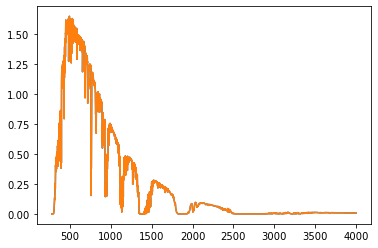

In [12]:
#Load the NREL AM1.5G spectra as the imput spectra
NREL_spectras = np.loadtxt('NREL_oficial_spectras.txt', skiprows=2)
AM15G_spectra = NREL_spectras[:,(0,2)]
fig, ax =plt.subplots()
ax.plot(AM15G_spectra[:,0], AM15G_spectra[:,1])
AM15G_spectra_fit = interpolate.interp1d(AM15G_spectra[:,0], AM15G_spectra[:,1])
ax.plot(AM15G_spectra[:,0], AM15G_spectra_fit(AM15G_spectra[:,0]))

### Plotting

In [13]:
# Here we will plot the loaded spectra data
def load_spectra_intplot(amp_factor, Initial_spectra, Final_spectra, custom_ymax = False, ymax = 2, AM15G = False):
    spectras_to_plot = np.arange(Initial_spectra, Final_spectra)
    gs = gridspec.GridSpec(2, 1)        # Create a 2x2 grid for plotting the cell parameters rainbow measurements
    fig = plt.figure(figsize=(15,12)) #(12,8) proportion
    ax1 = fig.add_subplot(gs[0, 0])     # RS
    ax2 = fig.add_subplot(gs[1, 0])     # BS

    for i in range(len(spectras_to_plot)):
        spectras_to_plot_indx = spectras_to_plot[i]
        ax1.plot(spectra_data_RS[:,0,spectras_to_plot_indx], amp_factor*spectra_data_RS[:,1, spectras_to_plot_indx])
        ax2.plot(spectra_data_BS[:,0,spectras_to_plot_indx], amp_factor*spectra_data_BS[:,1,spectras_to_plot_indx])
    
    if AM15G:
        ax1.plot(spectra_data_RS[:,0,0], AM15G_spectra_fit(spectra_data_RS[:,0,0]), color='tab:green', linewidth=2)#, linestyle = 'dotted')
        ax2.plot(spectra_data_RS[:,0,0], AM15G_spectra_fit(spectra_data_RS[:,0,0]), color='tab:green', linewidth=2)#, linestyle = 'dotted')


    ax1.set(xlabel="Wavelength [nm]", ylabel="Red sweep Irradiance [W m^-2 nm^-2]")
    ax2.set(xlabel="Wavelength [nm]", ylabel="Blue sweep Irradiance [W m^-2 nm^-2]")
    ax1.set_xlim(min(spectra_data_RS[:,0,0]), max(spectra_data_RS[:,0,0]))
    ax2.set_xlim(min(spectra_data_RS[:,0,0]), max(spectra_data_RS[:,0,0]))


    if custom_ymax:
        ax1.set_ylim(top=ymax)
        ax2.set_ylim(top=ymax)

    

        

In [14]:
widgets.interact(load_spectra_intplot, amp_factor=(0.5,2.5,0.1),Initial_spectra = np.arange(len(spectra_data_BS[0,0,:])), Final_spectra = np.arange(len(spectra_data_BS[0,0,:])), custom_ymax = False, ymax = 2, AM15G=False)  

interactive(children=(FloatSlider(value=1.5, description='amp_factor', max=2.5, min=0.5), Dropdown(description…

<function __main__.load_spectra_intplot(amp_factor, Initial_spectra, Final_spectra, custom_ymax=False, ymax=2, AM15G=False)>

## Motor position calibration

### Importing data

In [11]:
# import the cutwl motor position calibration file
divwl_motorpos_calibration = np.loadtxt(os.path.join(spectras_folder, 'Dividing Wavelength To Motor Position Calibration File_October2021.txt'), skiprows=1) #Cut wl reference (RS cutt WL) // RS (blue motor pos) // BS (red motor pos)

# Create a motor position vs measure for correlating the 3rd dimension of the spectra data matrix and the motor position
RS_motorpos = np.linspace(0,50, len(spectra_data_RS[0,0,:]))   
BS_motorpos = np.flip(RS_motorpos)


# c_matrix calculation methods

## Directly measured c_matrix

In [12]:
# In this section we will calculate the c_matrix as directly the spectra which motor position is closer to the cutting wavelength. 
c_matrix_min_wl = 360          # The minimum wavelength of the c_matrix spectras (and also the resulting EQE). Redomended value 400 because it is the minimum of EQE measures
c_matrix_max_wl = 1000         # The maximum wavelength of the c_matrix spectras (and also the resulting EQE). Recomended value 1000
c_matrix_res_wl = 1            # The wavelength resolution of the c_matrix spectras (and also the resultin EQE)
c_matrix_wl = np.arange(c_matrix_min_wl, c_matrix_max_wl, c_matrix_res_wl)          # This is the resulting list of wavelengths of the c_matrix (in the horizontal direction)
c_matrix_RS = np.zeros((len(RS_measure_megaarray[:,0,0]), len(c_matrix_wl)))        # We initialize the c_matrix_RS
c_matrix_BS = np.zeros((len(BS_measure_megaarray[:,0,0]), len(c_matrix_wl)))        # And the c_matrix_BS


for i in range(len(c_matrix_RS[:,0])):
    actual_cutwl = RS_measure_megaarray[i,0,0]
    actual_cutwl_indx = closest_indx(divwl_motorpos_calibration[:,0], actual_cutwl)
    actual_cutwl_motor_indx = closest_indx(RS_motorpos, divwl_motorpos_calibration[actual_cutwl_indx,1])
    actual_spectra_fit = interpolate.interp1d(spectra_data_RS[:,0,actual_cutwl_motor_indx], spectra_data_RS[:,1,actual_cutwl_motor_indx])
    for j in range(len(c_matrix_RS[0,:])):
        actual_wl = c_matrix_wl[j]
        actual_spectra_average = statistics.mean(actual_spectra_fit(np.linspace(actual_wl-(c_matrix_res_wl/2),actual_wl+(c_matrix_res_wl/2), c_matrix_res_wl*10)))
        c_matrix_RS[i,j] = actual_spectra_average*c_matrix_res_wl*actual_wl/1240 #Here is the key part. This spectra is the one corresponding to the c_matrix with all the multiplication factors (ie, divided by energy of the photon and multiplyed by Q in order to get the current density)
        #The summ of the product between c_matrix_spectra_single and the EQE directly give the Jsc in A/m^2 (in this case for the full spectra)
    
for i in range(len(c_matrix_BS[:,0])):
    actual_cutwl = BS_measure_megaarray[i,0,0]
    actual_cutwl_indx = closest_indx(divwl_motorpos_calibration[:,0], actual_cutwl)
    actual_cutwl_motor_indx = closest_indx(BS_motorpos, divwl_motorpos_calibration[actual_cutwl_indx,1])
    actual_spectra_fit = interpolate.interp1d(spectra_data_BS[:,0,actual_cutwl_motor_indx], spectra_data_BS[:,1,actual_cutwl_motor_indx])
    for j in range(len(c_matrix_BS[0,:])):
        actual_wl = c_matrix_wl[j]
        actual_spectra_average = statistics.mean(actual_spectra_fit(np.linspace(actual_wl-(c_matrix_res_wl/2),actual_wl+(c_matrix_res_wl/2), c_matrix_res_wl*10)))
        c_matrix_BS[i,j] = actual_spectra_average*c_matrix_res_wl*actual_wl/1240 #Here is the key part. This spectra is the one corresponding to the c_matrix with all the multiplication factors (ie, divided by energy of the photon and multiplyed by Q in order to get the current density)
        #The summ of the product between c_matrix_spectra_single and the EQE directly give the Jsc in A/m^2 (in this case for the full spectra)
    
        

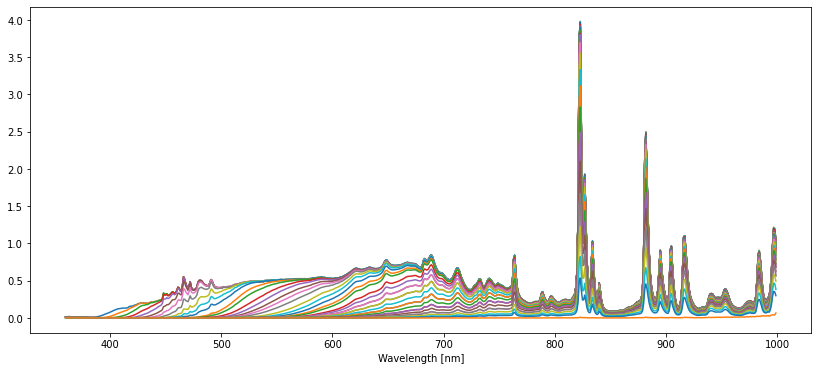

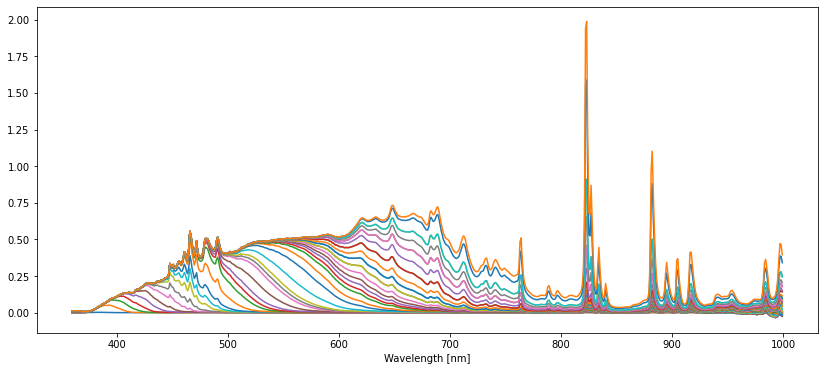

In [13]:
c_matrix_plotter(c_matrix_RS, c_matrix_wl)
c_matrix_plotter(c_matrix_BS, c_matrix_wl)

0 395.0


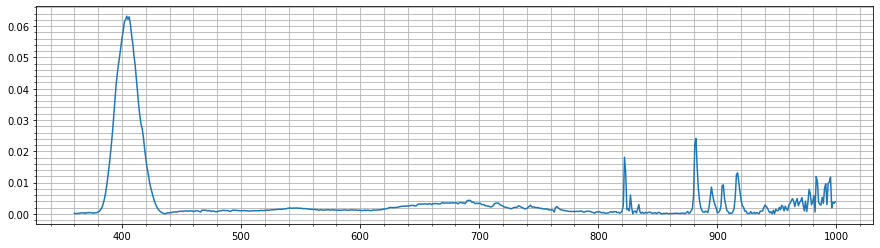

In [86]:
i=0
print(i, BS_measure_megaarray[i,0,0])
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(c_matrix_wl, abs(c_matrix_RS[i+1,:]-c_matrix_RS[i,:]))
ax.tick_params(axis='x', which='minor',  bottom=True)
plt.minorticks_on()
plt.grid(which='both')

In [ ]:
RS_central_wl = [405, 415, 425, 435, 450, 460, 470, 475, 480, 490, 505, 520, 525, 535, 550, 560, 565, 570, 590, 605, 620, 625, 640, 655, 660, 665, 670, 675, 680, 700, 710, 720, 740, 750, 760, 790, 815, 830, 840, 860, 880]

# Jsc data treatment

## Smoothening with splines

In [ ]:
def smoothening_intplot( RS_s_parameter, BS_s_parameter, cell_name = RS_cellname[0]):
    indx = [i for i, s in enumerate(RS_cellname) if cell_name in s][0]
    measured_Jsc_BS_fit = interpolate.UnivariateSpline(BS_measure_megaarray[:,0,indx], BS_measure_megaarray[:,2,indx], s=BS_s_parameter)
    measured_Jsc_RS_fit = interpolate.UnivariateSpline(RS_measure_megaarray[:,0,indx], RS_measure_megaarray[:,2,indx], s=RS_s_parameter)
    x_fit_plot = np.arange(min(BS_measure_megaarray[:,0,i]), max(BS_measure_megaarray[:,0,indx]), 1)

    gs = gridspec.GridSpec(1, 2)        # Create a 2x2 grid for plotting the cell parameters rainbow measurements
    fig = plt.figure(figsize=(25,8))
    ax1 = fig.add_subplot(gs[0, 0])     # Jsc plot
    ax2 = fig.add_subplot(gs[0, 1])     # Derivative   
        
    ax1.scatter(BS_measure_megaarray[:,0,indx], BS_measure_megaarray[:,2,indx], color='tab:blue', marker="x")
    ax1.plot(x_fit_plot, measured_Jsc_BS_fit(x_fit_plot), color='tab:blue')    
    ax2.plot(x_fit_plot, abs(measured_Jsc_BS_fit.derivative(n=1)(x_fit_plot)))

    ax1.scatter(RS_measure_megaarray[:,0,indx], RS_measure_megaarray[:,2,indx], color='tab:red', marker="x")
    ax1.plot(x_fit_plot, measured_Jsc_RS_fit(x_fit_plot), color='tab:red')    
    ax2.plot(x_fit_plot, abs(measured_Jsc_RS_fit.derivative(n=1)(x_fit_plot)))

In [ ]:
widgets.interact(smoothening_intplot, RS_s_parameter=(0.1, 10, 0.1), BS_s_parameter=(0.1, 10, 0.1),cell_name = RS_cellname)

interactive(children=(FloatSlider(value=5.0, description='RS_s_parameter', max=10.0, min=0.1), FloatSlider(val…

<function __main__.smoothening_intplot(RS_s_parameter, BS_s_parameter, cell_name='1FSC_A')>

# EQE resolution methods